<a href="https://colab.research.google.com/github/Satwikram/NLP-Implementations/blob/main/BERT/Quora%20-%20Insincere%20BERT%20Word%20Embeddings%20%2B%20LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Author: Satwik Ram K

### Connecting to Kaggle

In [1]:
from google.colab import files

files.upload()


! mkdir ~/.kaggle


! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


### Downloading dataset

In [2]:
!kaggle competitions download -c quora-insincere-questions-classification

 76% 12.0M/15.8M [00:00<00:00, 120MB/s]
100% 15.8M/15.8M [00:00<00:00, 101MB/s]
100% 5.96G/5.96G [01:56<00:00, 27.9MB/s]
100% 5.96G/5.96G [01:56<00:00, 54.7MB/s]
  0% 0.00/4.09M [00:00<?, ?B/s]
100% 4.09M/4.09M [00:00<00:00, 67.1MB/s]
100% 54.9M/54.9M [00:00<00:00, 68.4MB/s]



In [3]:
!unzip /content/train.csv.zip
!unzip /content/test.csv.zip

Archive:  /content/train.csv.zip
  inflating: train.csv               
Archive:  /content/test.csv.zip
  inflating: test.csv                


In [4]:
!pip install transformers

### Importing Dependencies

In [30]:
import numpy as np
import pandas as pd
import tensorflow as tf
from transformers import BertTokenizer, TFAutoModel
import os
from datetime import datetime
from pathlib import Path

from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, BatchNormalization, Input, Dropout
from tensorflow.keras.models import Model, load_model
import nltk

# nltk.download("stopwords")
# nltk.download("wordnet")

from nltk.corpus import stopwords
import re

In [6]:
dataset = pd.read_csv("/content/train.csv")

In [7]:
dataset.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [8]:
dataset = dataset.drop_duplicates(subset=['qid'], keep='first')

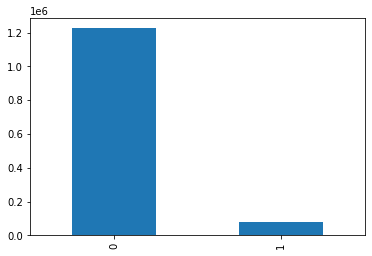

In [9]:
dataset["target"].value_counts().plot(kind = "bar")

In [10]:
dataset["target"].value_counts()

0    1225312
1      80810
Name: target, dtype: int64

In [26]:
class_0 = dataset[dataset["target"]==0].sample(n=80810, replace=False)
class_1 = dataset[dataset["target"]==1].sample(n=80810, replace=False)

df = pd.concat([class_0, class_1])

df["target"].value_counts()

1    80810
0    80810
Name: target, dtype: int64

### Clean Text

In [37]:
def clean_text(text):

  lem = nltk.stem.wordnet.WordNetLemmatizer()  # Lemmatization

  text = " ".join(map(lambda x: lem.lemmatize(x), text.split()))

  text = re.sub("\s+", " ", text)  # Remove extra spaces

  return text

In [38]:
df["question_text"] = df["question_text"].apply(clean_text)

### Feature Engineering

### Preparing inputs and outputs

In [ ]:
sequence_length = 512
num_samples = len(dataset)

num_samples, sequence_length

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")


tokens = tokenizer(dataset["Phrase"].tolist(), max_length = sequence_length, 
                   truncation = True, padding = "max_length", add_special_tokens = True,
                   return_tensors = "np")

arr = dataset["Sentiment"].values

labels = np.zeros((num_samples, arr.max()+1))

labels[np.arange(num_samples), arr] = 1

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

### Creating Dataset

In [ ]:
Xids = tokens["input_ids"]
Xmasks = tokens["attention_mask"]

dataset = tf.data.Dataset.from_tensor_slices((Xids, Xmasks, labels))

def map_fun(input_ids, masks, labels):

  return {"input_ids": input_ids,
          "attention_mask": masks}, labels

dataset = dataset.map(map_fun)

batch_size = 32

dataset = dataset.shuffle(10000).batch(batch_size, drop_remainder = True)

split = 0.9
size = int((Xids.shape[0] / batch_size)*split)

train_ds = dataset.take(size)
val_ds = dataset.skip(size)

### Building BERT Model

In [ ]:
bert = TFAutoModel.from_pretrained("bert-base-uncased")

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
input_ids = tf.keras.layers.Input(shape = (512,), name = "input_ids",
                                  dtype = "int32")

mask = tf.keras.layers.Input(shape = (512,), name = "attention_mask",
                                  dtype = "int32")

embeddings = bert(input_ids, attention_mask = mask)[0]
                                    
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512, return_sequences = True))(embeddings)
x = tf.keras.layers.BatchNormalization()(x)
                
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512))(x)
x = tf.keras.layers.BatchNormalization()(x)

y = tf.keras.layers.Dense(5, activation = "softmax", name = "outputs")(x)

model = tf.keras.Model(inputs = [input_ids, mask], outputs = y)

In [ ]:
model.layers[2].trainable = False

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 512,                                           

In [ ]:
optimizer = tf.keras.optimizers.Adam(lr = 5e-5, decay = 1e-6)
loss = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
model.compile(optimizer = optimizer, loss = loss, metrics = [acc])

### Callbacks

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("models", monitor = "val_loss", save_best_only = True, 
                                                verbose = 1)

earlystopping = tf.keras.callbacks.EarlyStopping( monitor = "val_loss", verbose = 1, restore_best_weights = True,
                                                 patience = 2)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_loss", factor = 0.2,
                              patience = 1, min_lr = 0.001, verbose = 1)

callbacks = [checkpoint, earlystopping, reduce_lr]

In [ ]:
history = model.fit(train_ds, validation_data =  val_ds, epochs = 1, callbacks = callbacks)

239/239 [==============================] - ETA: 0s - loss: 1.6179 - accuracy: 0.3652
Epoch 00001: val_loss improved from inf to 1.42802, saving model to models


INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


239/239 [==============================] - 1094s 5s/step - loss: 1.6179 - accuracy: 0.3652 - val_loss: 1.4280 - val_accuracy: 0.3160 - lr: 5.0000e-05


In [ ]:
lmodel = tf.saved_model.load("/content/models")

In [ ]:
infer = lmodel.signatures["serving_default"]

In [ ]:
tokens["attention_mask"][0].astype(np.int32).shape

(512,)

In [ ]:
tf.constant(tokens["attention_mask"][0].astype(np.int32), 1)

<tf.Tensor: shape=(512,), dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

In [ ]:
results = infer(attention_mask = tf.constant(tokens["attention_mask"][0].astype(np.int32)), input_ids = tf.constant(tokens["input_ids"][0].astype(np.int32)))